# Projeto 21: Previsão do preço de ações com Redes Neurais Recorrentes - Múltiplos Previsores

In [1]:
!pip install torch==1.4.0

## Etapa 1: Importação das bibliotecas

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
torch.manual_seed(123)

## Base de dados

In [4]:
df_train = pd.read_csv('/content/petr4_treinamento.csv')
df_test = pd.read_csv('/content/petr4_teste.csv')

In [5]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [6]:
df_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1240,2017-12-25,15.75,15.750000,15.75,15.750000,15.718563,0.0
1241,2017-12-26,15.75,15.990000,15.69,15.970000,15.938125,22173100.0
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [7]:
df_train.shape

(1245, 7)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1245 non-null   object 
 1   Open       1242 non-null   float64
 2   High       1242 non-null   float64
 3   Low        1242 non-null   float64
 4   Close      1242 non-null   float64
 5   Adj Close  1242 non-null   float64
 6   Volume     1242 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.2+ KB


In [9]:
df_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [10]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1.242000e+03
mean,14.041473,14.279831,13.785217,14.017415,13.699826,4.595294e+07
std,4.148311,4.186652,4.108178,4.146244,3.899735,3.235631e+07
min,4.200000,4.270000,4.120000,4.200000,4.191617,0.000000e+00
25%,10.510000,10.772500,10.210000,10.510000,10.489022,2.909925e+07
50%,14.545000,14.690000,14.220000,14.440000,14.209791,4.097120e+07
75%,17.187501,17.435001,16.870001,17.112501,16.383754,5.593528e+07
max,24.840000,24.900000,23.660000,24.559999,24.510979,6.989506e+08


In [12]:
df_grp = df_train.copy()
df_grp['Date'] = df_grp['Date'].apply(lambda x: x[:-3])
df_grp = df_grp.groupby('Date').mean().reset_index()
df_grp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01,19.698095,19.874762,19.384286,19.573810,17.979544,2.635205e+07
1,2013-02,17.565000,17.768889,17.337778,17.537778,16.109345,3.152355e+07
2,2013-03,18.376842,18.738421,18.130526,18.423158,16.922611,3.226189e+07
3,2013-04,18.240476,18.583810,17.998572,18.308095,16.833584,3.010713e+07
4,2013-05,19.997619,20.257143,19.766190,20.008095,18.726952,2.737860e+07


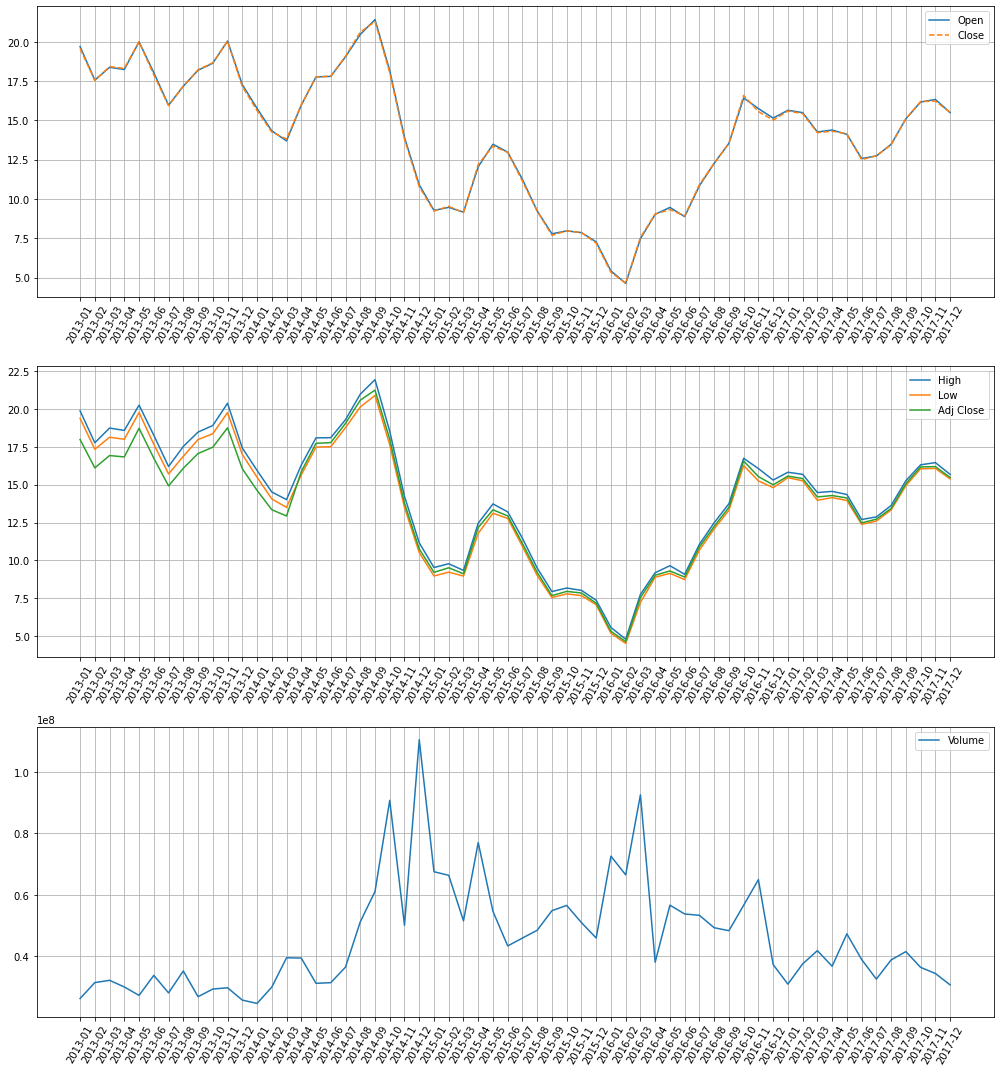

In [13]:
fig, ax = plt.subplots(3,1, figsize=(14,15))
ax[0].plot(df_grp['Date'], df_grp['Open'], label='Open')
ax[0].plot(df_grp['Date'], df_grp['Close'], label='Close', linestyle='--')
ax[0].xaxis.set_tick_params(rotation=60)
ax[0].grid()
ax[0].legend()

ax[1].plot(df_grp['Date'], df_grp['High'], label='High')
ax[1].plot(df_grp['Date'], df_grp['Low'], label='Low')
ax[1].plot(df_grp['Date'], df_grp['Adj Close'], label='Adj Close')
ax[1].xaxis.set_tick_params(rotation=60)
ax[1].grid()
ax[1].legend()

ax[2].plot(df_grp['Date'], df_grp['Volume'], label='Volume')
ax[2].xaxis.set_tick_params(rotation=60)
ax[2].grid()
ax[2].legend()

plt.tight_layout();

In [14]:
X_train = df_train.iloc[:,1:7].values
X_train

array([[1.9990000e+01, 2.0209999e+01, 1.9690001e+01, 1.9690001e+01,
        1.8086271e+01, 3.0182600e+07],
       [1.9809999e+01, 2.0400000e+01, 1.9700001e+01, 2.0400000e+01,
        1.8738441e+01, 3.0552600e+07],
       [2.0330000e+01, 2.0620001e+01, 2.0170000e+01, 2.0430000e+01,
        1.8766001e+01, 3.6141000e+07],
       ...,
       [1.5990000e+01, 1.6139999e+01, 1.5980000e+01, 1.6049999e+01,
        1.6017963e+01, 2.3552200e+07],
       [1.6100000e+01, 1.6129999e+01, 1.6000000e+01, 1.6100000e+01,
        1.6067865e+01, 1.9011500e+07],
       [1.6100000e+01, 1.6100000e+01, 1.6100000e+01, 1.6100000e+01,
        1.6067865e+01, 0.0000000e+00]])

In [15]:
train_scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = train_scaler.fit_transform(X_train)
X_scaled

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

In [16]:
X_scaled.shape

(1242, 6)

In [17]:
X, y = [], []
for i in range(90, X_scaled.shape[0]):
  X.append(X_scaled[i-90:i, 0:6])
  y.append(X_scaled[i, 0])
X, y = np.array(X), np.array(y)

In [18]:
X[0]

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       [0.78875969, 0.7949588 , 0.81013311, 0.77996075, 0.70144373,
        0.04015963],
       [0.77083338, 0.77363063, 0.78505624, 0.75147351, 0.67522435,
        0.0416214 ],
       [0.74806197, 0.75618037, 0.78505624, 0.76031438, 0.68336137,
        0.03485382],
       [0.75436047, 0.76490543, 0.78915051, 0.76768177, 0.69014234,
        0.02507502],
       [0.75823643, 0.76442079, 0.79733884, 0.77013751, 0.6924025 ,
        0.0260728 ],
       [0.76598837, 0.77411537, 0.79682707, 0.76227897, 0.68516964,
        0.0404927 ],
       [0.76598837, 0.77411537, 0.79682707, 0.76719061, 0.68969016,
        0.0423977 ],
       [0.76017437, 0.75714973, 0.79222108, 0.76817293, 0.69059437,
        0.02401858],
       [0.75872098, 0

In [19]:
y[0]

0.7611434108527131

In [20]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [21]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Etapa 3: Construção da rede neural recorrente

In [22]:
class Reg_LSTM(nn.Module):
  def __init__(self):
    super(Reg_LSTM, self).__init__()

    self.lstm1 = nn.LSTM(input_size=6, hidden_size=100)
    self.lstm2 = nn.LSTM(100, 50)
    self.lstm3 = nn.LSTM(50,50, dropout=0.3, num_layers=2)
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(in_features=50, out_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    # X = (batch_size, timesteps) => (timesteps, batch_size, dimensions)
    X = X.permute(1, 0, 2)
    X, _ = self.lstm1(X)
    X = self.dropout(X)
    X, _ = self.lstm2(X)
    X = self.dropout(X)
    X, _ = self.lstm3(X)

    X = X[-1]
    X = self.dropout(X)
    X = self.linear(X)
    X = self.sigmoid(X)

    return X

In [23]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [24]:
reg = Reg_LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters())

In [25]:
reg.to(device)

Reg_LSTM(
  (lstm1): LSTM(6, 100)
  (lstm2): LSTM(100, 50)
  (lstm3): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Etapa 4: Treinamento do modelo

In [26]:
# Variáveis para o callback
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

# Inicializando o custo inicial para usar o callback
min_loss = np.inf

In [27]:
arr_loss, arr_mae = [], []
for epoch in range(200):

  run_loss = 0.
  run_mae = 0.

  for i, data in enumerate(loader):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = reg(inputs)
    outputs = outputs.flatten()

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    run_loss += loss.item()
    mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                              outputs.detach().cpu().numpy().flatten())
    
    run_mae += mae

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: custo {:03.5f} | MAE {:03.5f}' \
          .format(epoch+1, i+1, len(loader), loss, mae), end='\r')
    
  run_loss /= len(loader)
  run_mae /= len(loader)
  arr_loss.append(run_loss)
  arr_mae.append(run_mae)
  print('ÉPOCA {:3d} FINALIZADA: custo {:03.6f} | MAE {:03.6f}      ' \
        .format(epoch+1, run_loss, run_mae))


  # SALVAR O MODELO
  if run_loss < min_loss:
    print('** Custo reduzido de {:03.6f} >>> {:03.6f} ... SALVANDO CHECKPOINT\n' \
          .format(min_loss, run_loss))
    torch.save(reg.state_dict(), 'checkpoint.pth')
    min_loss = run_loss
    es_patience = 0
    rlr_patience = 0

  else:
    print('**Custo não reduziu, não salva checkpoint\n')
    # OS DEMAIS PARÂMETROS SÓ SERÃO CONSIDERADOS SE O CUSTO NÃO TIVER
    # PARADA ANTECIPADA
    if run_loss - min_loss >= ES_MIN_DELTA:
      es_patience += 1

      if es_patience == ES_PATIENCE:
        print('--Critério de parada antecipada alcaçado, parando o treinamento.')
        break

    # REDUZIR A TAXA DE APRENDIZAGEM
    rlr_patience += 1
    if rlr_patience == RLR_PATIENCE:
      print('--Critério de redução de taxa de aprendizagem alcançado, reduzindo LR.')
      for param_group in optimizer.param_groups:
        param_group['lr'] *= RLR_FACTOR
      
      rlr_patience = 0

ÉPOCA   1 FINALIZADA: custo 0.024224 | MAE 0.118907      
** Custo reduzido de inf >>> 0.024224 ... SALVANDO CHECKPOINT

ÉPOCA   2 FINALIZADA: custo 0.005203 | MAE 0.055632      
** Custo reduzido de 0.024224 >>> 0.005203 ... SALVANDO CHECKPOINT

ÉPOCA   3 FINALIZADA: custo 0.003576 | MAE 0.045800      
** Custo reduzido de 0.005203 >>> 0.003576 ... SALVANDO CHECKPOINT

ÉPOCA   4 FINALIZADA: custo 0.002903 | MAE 0.040878      
** Custo reduzido de 0.003576 >>> 0.002903 ... SALVANDO CHECKPOINT

ÉPOCA   5 FINALIZADA: custo 0.002708 | MAE 0.039645      
** Custo reduzido de 0.002903 >>> 0.002708 ... SALVANDO CHECKPOINT

ÉPOCA   6 FINALIZADA: custo 0.002234 | MAE 0.036184      
** Custo reduzido de 0.002708 >>> 0.002234 ... SALVANDO CHECKPOINT

ÉPOCA   7 FINALIZADA: custo 0.002287 | MAE 0.036754      
**Custo não reduziu, não salva checkpoint

ÉPOCA   8 FINALIZADA: custo 0.002263 | MAE 0.035954      
**Custo não reduziu, não salva checkpoint

ÉPOCA   9 FINALIZADA: custo 0.002264 | MAE 0.03

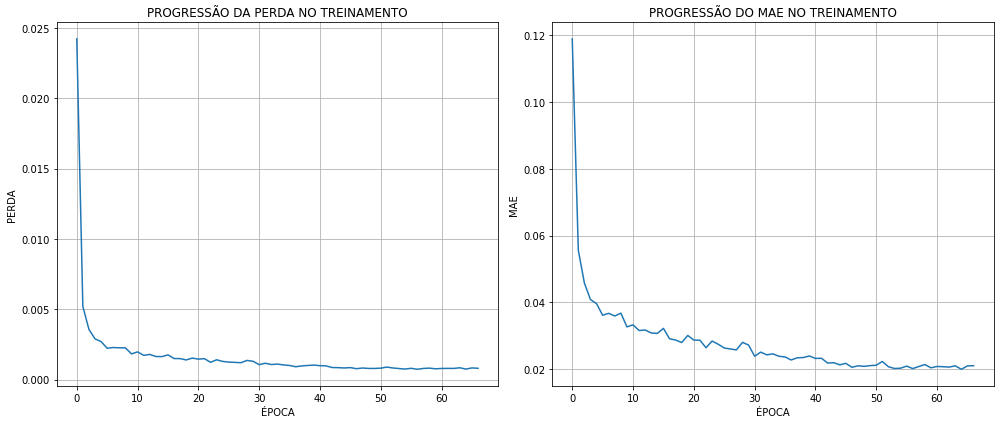

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].plot(arr_loss, label='Perda')
ax[0].set(xlabel='ÉPOCA', ylabel='PERDA', title='PROGRESSÃO DA PERDA NO TREINAMENTO')
ax[0].grid()

ax[1].plot(arr_mae, label='MAE')
ax[1].set(xlabel='ÉPOCA', ylabel='MAE', title='PROGRESSÃO DO MAE NO TREINAMENTO')
ax[1].grid()

plt.tight_layout();

## Etapa 5: Processamento da base de teste

In [29]:
y_raw = df_test.iloc[:, 1:2].values
df_completa = pd.concat([df_train, df_test])
df_completa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [30]:
df_completa.drop('Date', axis=1, inplace=True)

In [31]:
entradas = df_completa[len(df_completa) - len(df_test) - 90:].values
entradas = train_scaler.transform(entradas)

In [32]:
X_test = []
for i in range(90, 112):
  X_test.append(entradas[i-90:i, 0:6])
X_test = np.array(X_test)

In [33]:
X_test = torch.tensor(X_test, device = device, dtype=torch.float32)

## Etapa 6: Previsões

In [34]:
reg.eval()
previsoes = reg.forward(X_test)
previsoes = previsoes.detach().cpu().numpy().reshape(-1,1)
previsoes

array([[0.5791358 ],
       [0.5879238 ],
       [0.60090023],
       [0.61196864],
       [0.61542016],
       [0.6182297 ],
       [0.6228692 ],
       [0.62005526],
       [0.62337714],
       [0.6312442 ],
       [0.6380664 ],
       [0.6470777 ],
       [0.6702178 ],
       [0.68560696],
       [0.6873043 ],
       [0.6865788 ],
       [0.683122  ],
       [0.7055072 ],
       [0.73149306],
       [0.7494985 ],
       [0.7572594 ],
       [0.75082487]], dtype=float32)

In [35]:
test_scaler = MinMaxScaler(feature_range=(0,1))
test_scaler.fit(X_train[:,0:1])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [36]:
previsoes = test_scaler.inverse_transform(previsoes)
previsoes.mean()

17.807087

In [37]:
y_raw.mean()

17.87454563636364

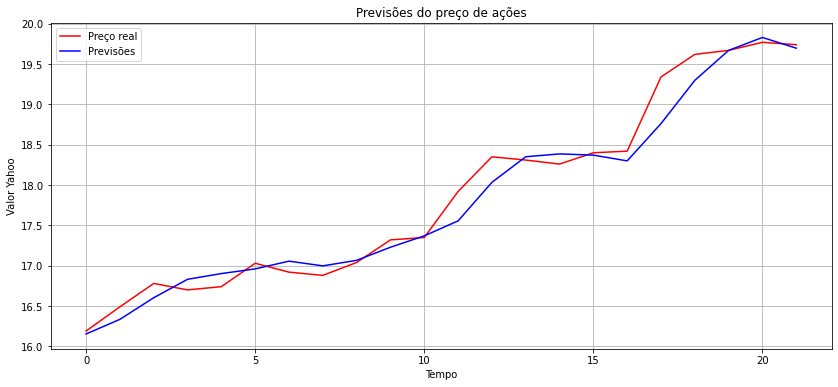

In [39]:
plt.figure(figsize=(14,6))
plt.plot(y_raw, color='red', label='Preço real')
plt.plot(previsoes, color = 'blue', label='Previsões')
plt.title('Previsões do preço de ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.grid()
plt.show()